In [105]:
import pandas as pd
dating = pd.read_csv("profiles.csv")

In [106]:
# basic data cleanup
# income
dating.loc[dating["income"] == -1, "income"] = pd.NA

# Let's create ML algorithm that will predict drug use on empty fields

prepare data some more for drug investigation

In [107]:
# create some suspicios words list that may relate to drug use to filter from essays
drug_words = ["party", "fun", "hang out", "festival", "good time", "drink"]
essay_cols = [col for col in dating.columns if col.startswith("essay")]
for word in drug_words:
    dating[word + "_count"] = dating[essay_cols].apply(
        lambda row: sum(str(cell).lower().count(word) for cell in row if pd.notna(cell)),
        axis=1
    )
    
dating = dating.drop(columns=essay_cols)

Prepare data for machine learning

In [108]:
drugs_values = dating["drugs"].value_counts()
dating_drugs_filled = dating.dropna(subset=["drugs"])
dating_drugs_missing = dating[dating["drugs"].isna()]
features = dating_drugs_filled.drop(columns=["drugs"])
labels = dating_drugs_filled["drugs"]
features["education"][features["education"].str.contains("graduated", na=False)].value_counts()
features["religion"].value_counts()
labels.value_counts(normalize=True)

drugs
never        0.822483
sometimes    0.168578
often        0.008939
Name: proportion, dtype: float64

In [109]:
# prepare features for ML
features = pd.get_dummies(features, columns=["body_type", "drinks", "job", "orientation", "pets"], dummy_na=False)

from tools import bucket_education, is_strict_diet

# extract most common single ethnicities (about 5), rest as "other"
# literal list based on value_counts and inspection
ethnicities = [
    "white",
    "asian",
    "black",
    "hispanic / latin",
    "other",
    "middle eastern",
    "native american",
    "pacific islander",
    "indian"
]
for ethn in ethnicities:
    features[ethn] = features["ethnicity"].apply(lambda val: True if pd.notna(val) and ethn in val else False)

features["education_bucket"] = features["education"].apply(bucket_education)
features = pd.get_dummies(features, columns=["education_bucket"], dummy_na=False)
features["male"] = features["sex"].apply(lambda val: True if val == "m" else False)
features["smokes"] = features["smokes"].apply(lambda val: False if val == "no" else True)
features["is_single"] = features["status"].apply(lambda val: True if val == "single" else False)
features["has_kid_s"] = features["offspring"].apply(lambda val: True if pd.notna(val) and "has" in val else False)
features["strict_diet"] = features["diet"].apply(is_strict_diet)
features["strict_religion"] = features["religion"].apply(lambda val: True if pd.notna(val) and "very serious about it" in val else False)
diets = ["vegan", "vegetarian", "halal", "kosher"]
for diet in diets:
    features[diet] = features["diet"].apply(lambda val: True if pd.notna(val) and diet in val else False)

features = features.select_dtypes(include=["number", "bool"])

In [110]:
education_unique = dating["education"].dropna().unique()
education_buckets = {edu: bucket_education(edu) for edu in education_unique}
education_buckets

{'working on college/university': 'high_school',
 'working on space camp': 'lower',
 'graduated from masters program': 'graduated',
 'graduated from college/university': 'graduated',
 'working on two-year college': 'high_school',
 'graduated from high school': 'high_school',
 'working on masters program': 'high_school',
 'graduated from space camp': 'high_school',
 'college/university': 'graduated',
 'dropped out of space camp': 'lower',
 'graduated from ph.d program': 'Ph.D',
 'graduated from law school': 'high_school',
 'working on ph.d program': 'graduated',
 'two-year college': 'graduated',
 'graduated from two-year college': 'graduated',
 'working on med school': 'lower',
 'dropped out of college/university': 'high_school',
 'space camp': 'high_school',
 'graduated from med school': 'high_school',
 'dropped out of high school': 'lower',
 'working on high school': 'lower',
 'masters program': 'graduated',
 'dropped out of ph.d program': 'graduated',
 'dropped out of two-year colleg

let's go with decision tree model

In [111]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import make_scorer, f1_score

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=21)
dtree = DecisionTreeClassifier(class_weight="balanced", max_depth=10, random_state=10)
dtree.fit(x_train, y_train)
tree_text = tree.export_text(dtree, feature_names=list(x_train.columns))
print(tree_text)

|--- smokes <= 0.50
|   |--- income <= 375000.00
|   |   |--- orientation_bisexual <= 0.50
|   |   |   |--- drinks_often <= 0.50
|   |   |   |   |--- age <= 27.50
|   |   |   |   |   |--- education_bucket_graduated <= 0.50
|   |   |   |   |   |   |--- job_artistic / musical / writer <= 0.50
|   |   |   |   |   |   |   |--- drinks_socially <= 0.50
|   |   |   |   |   |   |   |   |--- education_bucket_high_school <= 0.50
|   |   |   |   |   |   |   |   |   |--- height <= 70.50
|   |   |   |   |   |   |   |   |   |   |--- class: never
|   |   |   |   |   |   |   |   |   |--- height >  70.50
|   |   |   |   |   |   |   |   |   |   |--- class: often
|   |   |   |   |   |   |   |   |--- education_bucket_high_school >  0.50
|   |   |   |   |   |   |   |   |   |--- drink_count <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: never
|   |   |   |   |   |   |   |   |   |--- drink_count >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: often
|   |   |   |   |   |   |   |--- dr

In [112]:
from sklearn.metrics import classification_report
from tools import get_report

get_report(dtree, x_test, y_test)

Macro-F1: 0.7376968172674336
0.7483778715815311
              precision    recall  f1-score   support

       never       0.91      0.76      0.83      7528
   sometimes       0.35      0.49      0.41      1563
       often       0.05      0.42      0.09        83

    accuracy                           0.71      9174
   macro avg       0.44      0.56      0.44      9174
weighted avg       0.81      0.71      0.75      9174

 0.7376968172674336
0.7483778715815311
              precision    recall  f1-score   support

       never       0.91      0.76      0.83      7528
   sometimes       0.35      0.49      0.41      1563
       often       0.05      0.42      0.09        83

    accuracy                           0.71      9174
   macro avg       0.44      0.56      0.44      9174
weighted avg       0.81      0.71      0.75      9174



We see very poor performance by the decision tree model.
Let's try something, that takes in account the ordinality of labels.

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
ord_map = {'never': 0, 'sometimes': 1, 'often': 2}
labels = labels.map(ord_map)
scaler = StandardScaler()
imputer = SimpleImputer(strategy="median")
# Apply scaler only to int and float columns
num_cols = features.select_dtypes(include=["int", "float"]).columns
features[num_cols] = scaler.fit_transform(features[num_cols])
features[num_cols] = imputer.fit_transform(features[num_cols])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=21)
log_regressor = LogisticRegression(random_state=10, max_iter=1000)
log_regressor.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=10)

Not thresholded:
Macro-F1: 0.8098505000957094
0.8081334687746531
              precision    recall  f1-score   support

       never       0.86      0.97      0.91      7528
   sometimes       0.58      0.26      0.36      1563
       often       0.33      0.02      0.04        83

    accuracy                           0.84      9174
   macro avg       0.59      0.42      0.44      9174
weighted avg       0.81      0.84      0.81      9174

Macro-F1: 0.8098505000957094
0.8081334687746531
              precision    recall  f1-score   support

       never       0.86      0.97      0.91      7528
   sometimes       0.58      0.26      0.36      1563
       often       0.33      0.02      0.04        83

    accuracy                           0.84      9174
   macro avg       0.59      0.42      0.44      9174
weighted avg       0.81      0.84      0.81      9174



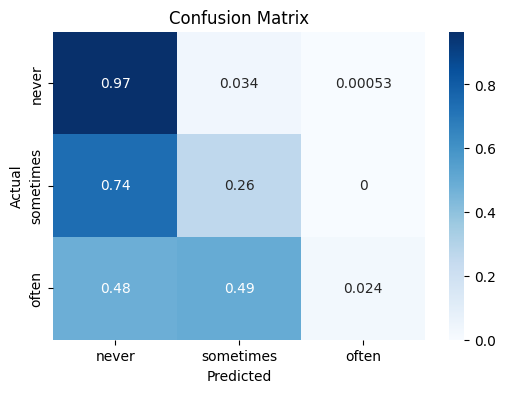

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# evaluate performance
y_pred = log_regressor.predict(x_test)
print("Not thresholded:")
get_report(log_regressor, x_test, y_test)
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Best 'often' thresh: 0.09896755439047003 F1_often: 0.24581005586542443
Best 'sometimes' thresh: 0.2382997131172823 F1_sometimes: 0.5107451855981718
Thresholded: 
0.8099827987151159
              precision    recall  f1-score   support

       never       0.91      0.85      0.88      7528
   sometimes       0.44      0.58      0.50      1563
       often       0.22      0.25      0.24        83

    accuracy                           0.80      9174
   macro avg       0.53      0.56      0.54      9174
weighted avg       0.83      0.80      0.81      9174



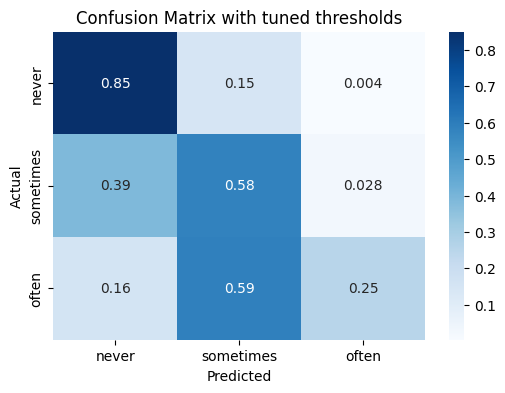

In [115]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve
from tools import get_best_thresholds, predict_with_thresholds

# 1) Get predicted probabilities on a hold-out (validation) set
probs = log_regressor.predict_proba(x_test)  
# probs[:,0] = P(never), probs[:,1]=P(sometimes), probs[:,2]=P(often)

t_opt_o, t_opt_s = get_best_thresholds(probs, y_test)

y_pred_thr = predict_with_thresholds(probs, t_opt_o, t_opt_s)

print("Thresholded: ")
print(f1_score(y_test, y_pred_thr, average="weighted"))

unique_labels = y_test.value_counts().index.tolist()
print(
    classification_report(
        y_test,
        y_pred_thr,
        labels=unique_labels,
        target_names=["never", "sometimes", "often"],
        zero_division=0,  # avoid ‘undefined’ warnings if a class is missing
    )
)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds')
plt.show()

In [118]:
from imblearn.over_sampling import SMOTENC

# Identify which feature indices are truly categorical/boolean
cat_idxs = [x_train.columns.get_loc(c) for c in x_train.columns if c not in num_cols]

smote_nc = SMOTENC(
    categorical_features=cat_idxs,
    random_state=42
)

x_res, y_res = smote_nc.fit_resample(x_train, y_train)
log_regressor.fit(x_res, y_res)

LogisticRegression(max_iter=1000, random_state=10)

Macro-F1: 0.8098505000957094
0.7634577739534688
              precision    recall  f1-score   support

       never       0.88      0.81      0.84      7528
   sometimes       0.36      0.47      0.41      1563
       often       0.04      0.13      0.07        83

    accuracy                           0.75      9174
   macro avg       0.43      0.47      0.44      9174
weighted avg       0.79      0.75      0.76      9174

Thresholded: 
0.6466121699378108
              precision    recall  f1-score   support

       never       0.92      0.58      0.71      7528
   sometimes       0.26      0.59      0.36      1563
       often       0.03      0.34      0.06        83

    accuracy                           0.58      9174
   macro avg       0.40      0.50      0.38      9174
weighted avg       0.80      0.58      0.65      9174



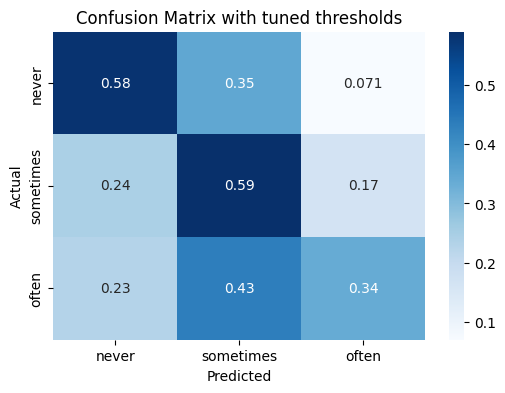

In [120]:
get_report(log_regressor, x_test, y_test)
# 5) Evaluate on your test set
probs_test = log_regressor.predict_proba(x_test)
y_pred_thr = predict_with_thresholds(probs_test, t_opt_o, t_opt_s)

print("Thresholded: ")
print(f1_score(y_test, y_pred_thr, average="weighted"))

unique_labels = y_test.value_counts().index.tolist()
print(
    classification_report(
        y_test,
        y_pred_thr,
        labels=unique_labels,
        target_names=["never", "sometimes", "often"],
        zero_division=0,  # avoid ‘undefined’ warnings if a class is missing
    )
)


cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds')
plt.show()